In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy
import arviz as az
import pymc3 as pm
from tqdm import tqdm
import theano
import theano.tensor as tt
import pandas as pd
import datetime

In [2]:
from tools import *
from existing import SIR_Model
from model import Convolution
from utils import DataReader

In [3]:
theano.config.floatX= 'float64'
az.style.use("arviz-darkgrid")

In [4]:
de_covid19_csv = "dataset/DE_COVID19.csv"
de_covid19_df = pd.read_csv(de_covid19_csv)
de_policy_csv = "dataset/DE_Policy.csv"
de_policy_df = pd.read_csv(de_policy_csv)

In [5]:
d = DataReader("DE", de_covid19_df, de_policy_df)
d.start_date = datetime.date(2020, 2, 29)
d.end_date = datetime.date(2020, 5, 1)
fit_start_date = datetime.datetime.strptime(d.start_date, "%Y-%m-%d").date()
fit_end_date = datetime.date(2020, 4, 11)
fit_ndays = (fit_end_date - fit_start_date).days + 1

In [6]:
Id_covid19_series = d.confirmed_cases_new
Rd_covid19_series = d.recovered_cases_new
Dd_covid19_series = d.deaths_cases_new
policy_series = d.policy_series

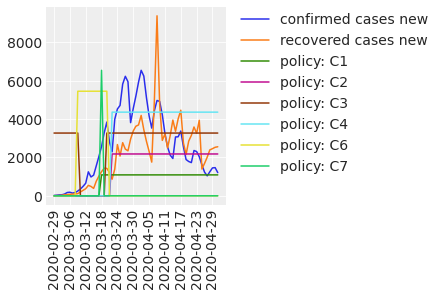

In [7]:
d.plot()

In [8]:
policy_series = []
change_point1 = (datetime.date(2020, 3, 9) - datetime.date(2020, 2, 29)).days + 1
change_point2 = (datetime.date(2020, 3, 21) - datetime.date(2020, 2, 29)).days + 1
for i in range(change_point1):
    policy_series.append([0, 0])
    pass
for i in range(change_point2-change_point1):
    policy_series.append([1, 0])
    pass
for i in range((len(d.dates)-change_point2)):
    policy_series.append([0, 1])
    pass
print(np.array(policy_series).shape)

(63, 2)


In [9]:
with pm.Model() as model:
    
    n_steps = len(d.dates)
    
    N = 0.83 * 1e8
    
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    
    I_begin = pm.HalfCauchy(name=r"$I_{0}$", beta=500)
    S_begin = N - I_begin
    
    # Error term    
    eps = pm.HalfNormal(r'$\varepsilon_{i(t)}$')
        
    beta0 = PositiveNormal(r'$\beta_{0}$', mu=1.375, sigma=0.01)
        
    gamma = PositiveNormal(r'$\gamma$', mu=1.1, sigma=0.01)
    
    change_beta_1 = pm.Uniform(r"Change in $\beta(t)$ on March 9, 2020", \
                               lower=-1.0, upper=1.0)
    change_beta_1 = tt.reshape(change_beta_1, newshape=(1,))
    change_beta_2 = pm.Uniform(r"Change in $\beta(t)$ on March 21, 2020", \
                               lower=-1.0, upper=1.0)
    change_beta_2 = tt.reshape(change_beta_2, newshape=(1,))
    policy_weights = tt.concatenate([change_beta_1, change_beta_2], axis=0)
    
    policy_series = np.array(policy_series)
    S, I, new_I, new_R, betat = SIR_Model(beta0, gamma, S_begin, I_begin, N, policy_series, policy_weights)
    
    new_I_ = pm.Deterministic(r'$i(t)$', new_I)
    betat_ = pm.Deterministic(r'$\beta(t)$', betat)
    
    obs_fit = pm.Normal('Fit', mu=new_I[:fit_ndays], sigma=eps*new_I[:fit_ndays], shape=(len(Id_covid19_series[:fit_ndays])), \
                        observed=Id_covid19_series[:fit_ndays])  
    obs_forecast = pm.Deterministic('Forecast', new_I[fit_ndays:])
    
    step1 = pm.Metropolis(vars=[new_I])
    step2 = pm.Slice(vars=[eps])
    trace = pm.sample(4000, cores=4, chains=4, tune=6000, step=[step1, step2], init='advi', \
                      return_inferencedata=True)
    
    pass

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [$I_{0}$]
>>Metropolis: [Change in $\beta(t)$ on March 9, 2020]
>>Metropolis: [Change in $\beta(t)$ on March 21, 2020]
>>Metropolis: [$\beta_{0}$]
>>Metropolis: [$\gamma$]
>Slice: [$\varepsilon_{i(t)}$]


Sampling 4 chains for 6_000 tune and 4_000 draw iterations (24_000 + 16_000 draws total) took 48 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


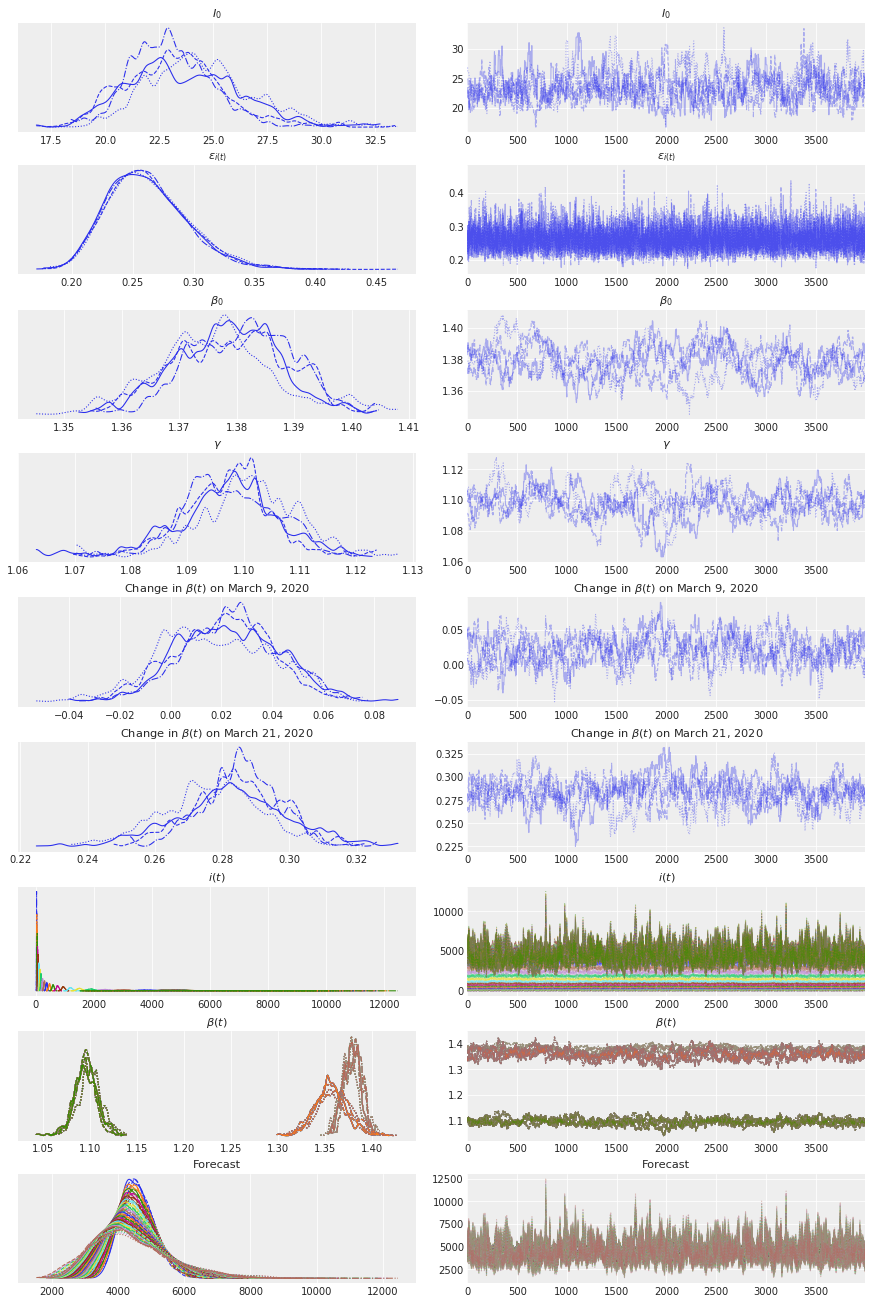

In [10]:
az.plot_trace(trace)
plt.show()

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$I_{0}$,23.587,2.393,19.267,28.081,0.234,0.167,111.0,409.0,1.04
$\varepsilon_{i(t)}$,0.262,0.033,0.204,0.323,0.001,0.000,4110.0,6972.0,1.00
$\beta_{0}$,1.379,0.010,1.360,1.396,0.001,0.001,76.0,162.0,1.03
$\gamma$,1.098,0.009,1.082,1.115,0.001,0.001,93.0,175.0,1.05
"Change in $\beta(t)$ on March 9, 2020",0.021,0.020,-0.015,0.060,0.002,0.001,125.0,398.0,1.01
...,...,...,...,...,...,...,...,...,...
Forecast[15],4413.787,1051.063,2591.601,6467.725,40.339,28.536,651.0,1017.0,1.01
Forecast[16],4402.387,1084.795,2598.546,6599.101,41.763,29.543,646.0,1012.0,1.01
Forecast[17],4391.037,1118.417,2497.184,6613.314,43.177,30.544,641.0,1002.0,1.01
Forecast[18],4379.735,1151.926,2329.156,6553.732,44.581,31.537,637.0,973.0,1.01


E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (152) in plot_posterior, generating only 40 plots
  warnings.warn(


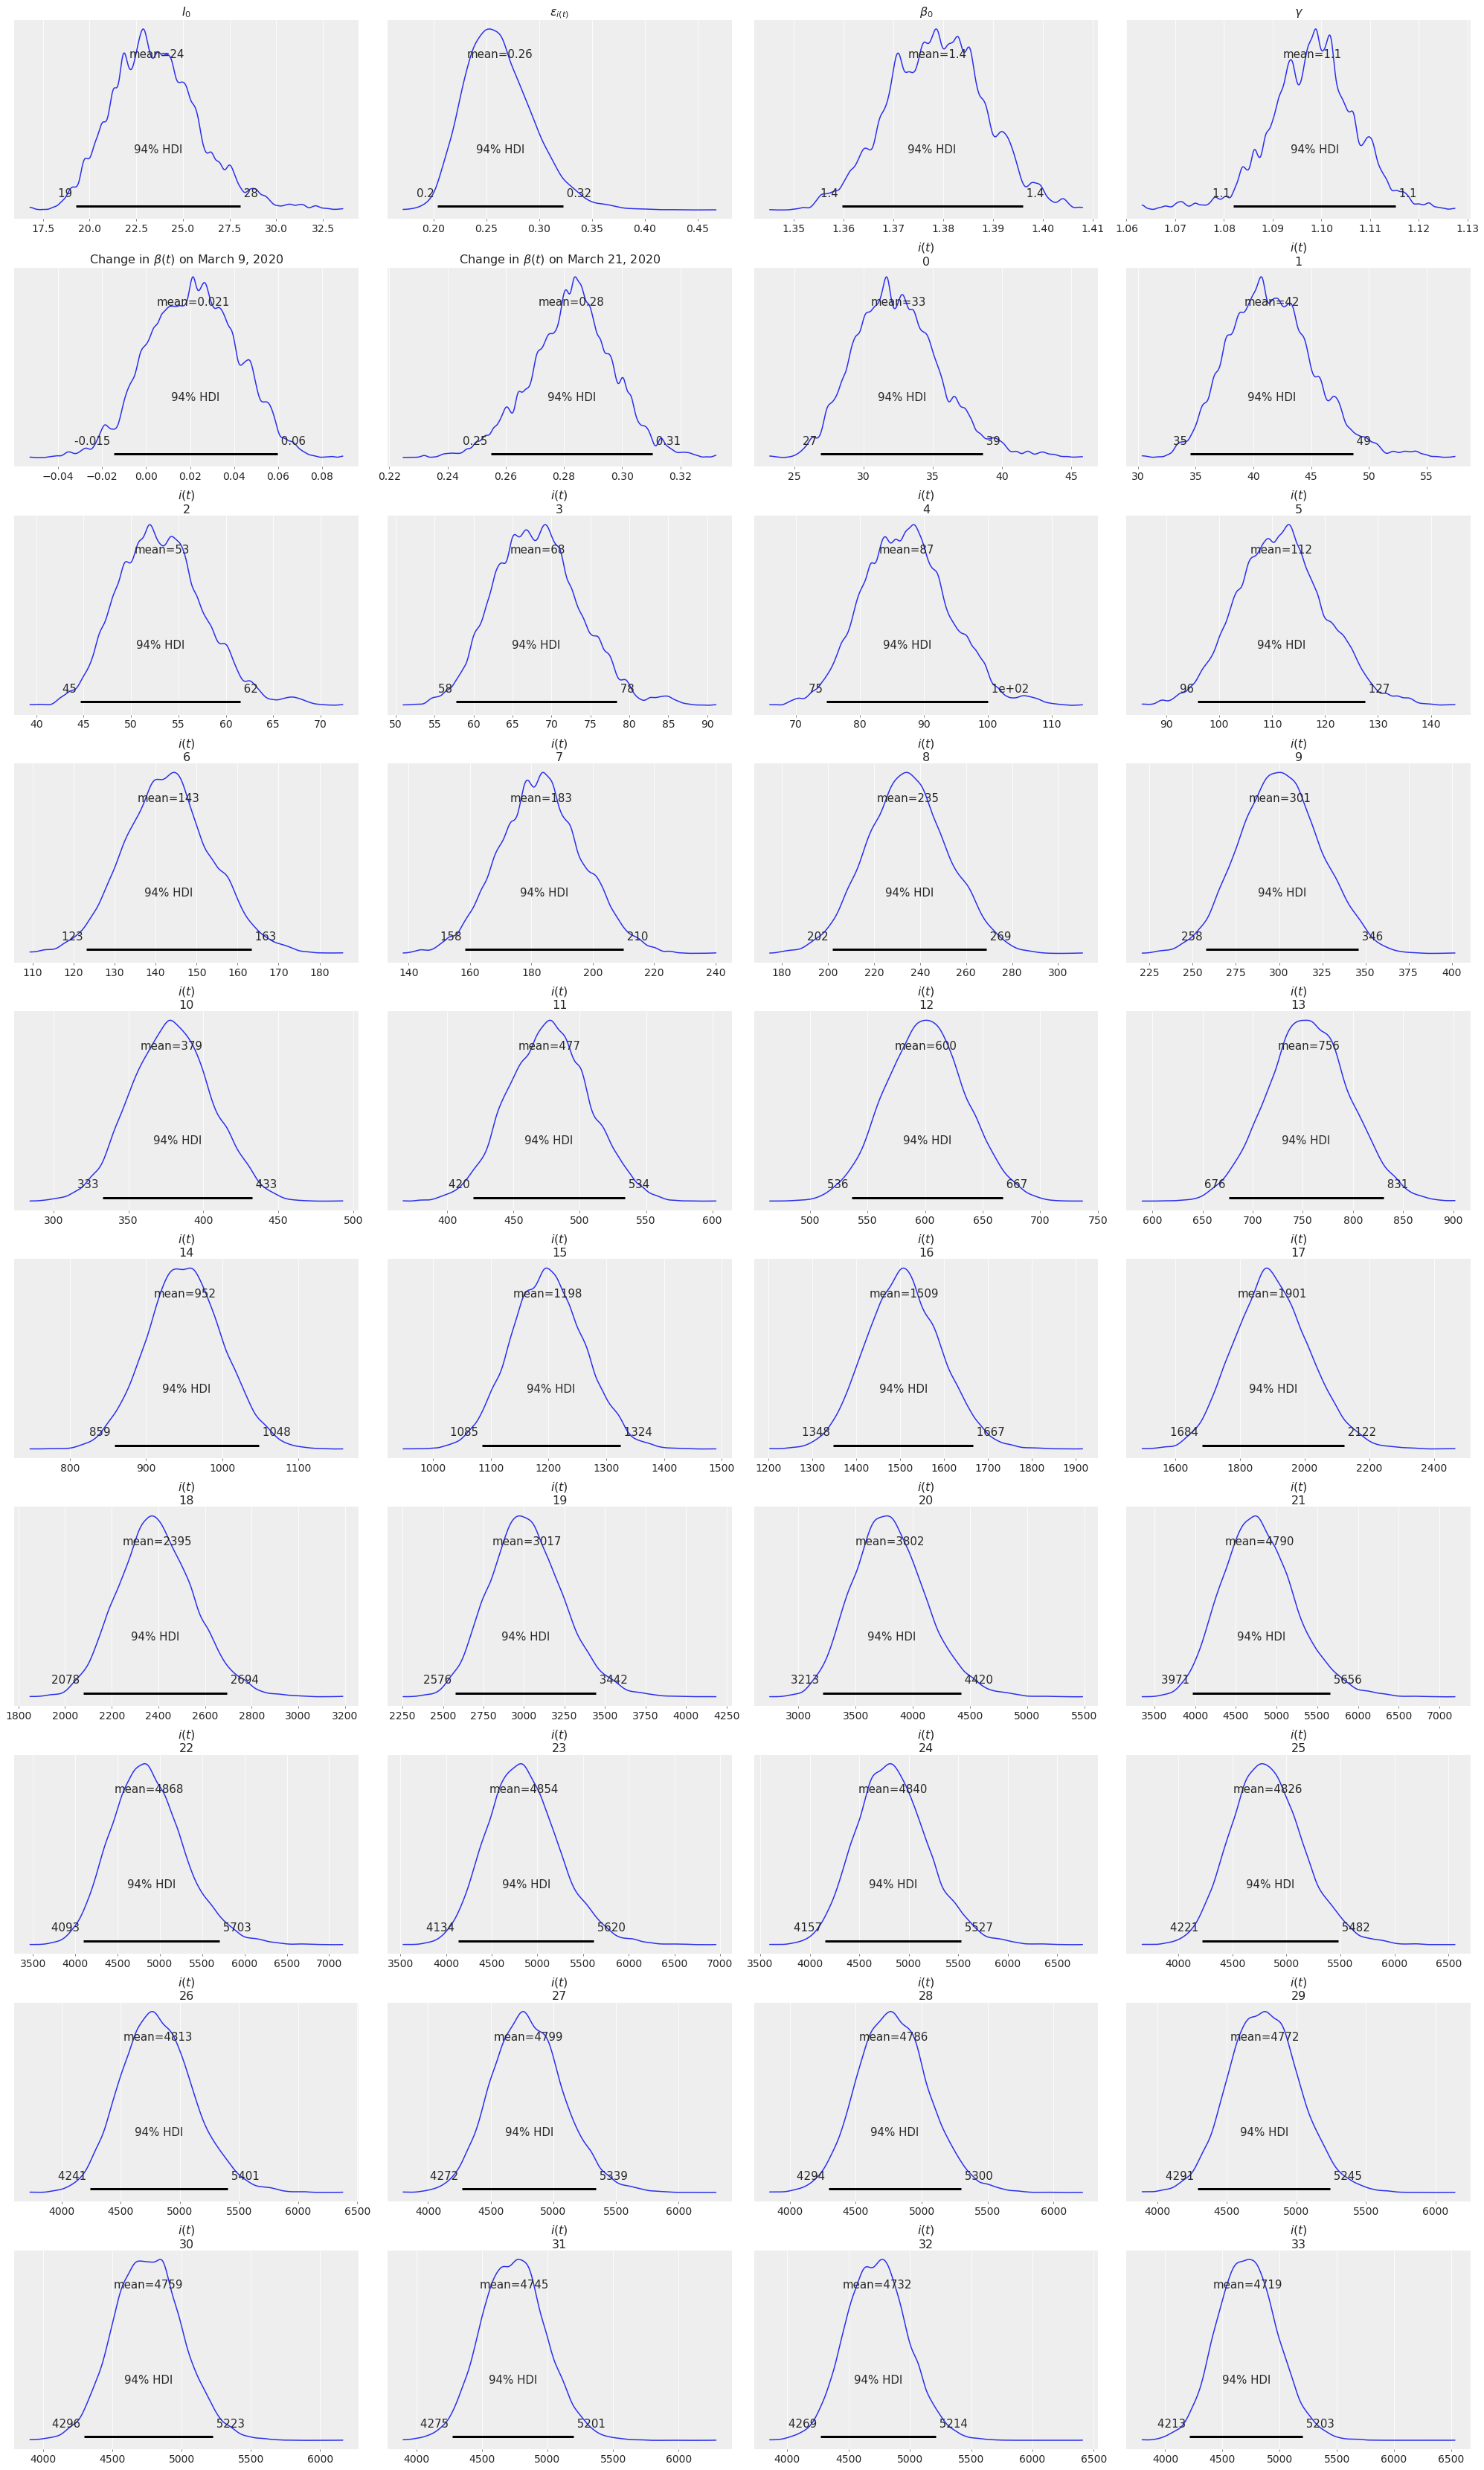

In [12]:
az.plot_posterior(trace)
plt.show()

In [13]:
with model:
    pp = pm.sample_posterior_predictive(trace, samples=1000, \
                                        var_names=["Fit", "Forecast", \
                                                   r'$\varepsilon_{i(t)}$', r'$\beta(t)$'])
    pp_fit = pp["Fit"]
    dtm_forecast = pp["Forecast"]
    pp_eps = pp[r'$\varepsilon_{i(t)}$']
    pp_betat = pp[r'$\beta(t)$']
    pass

E:\anaconda3\envs\covid19bayes\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [14]:
pp_forecast = pm.Normal.dist(mu=dtm_forecast, sigma=dtm_forecast*pp_eps.reshape((pp_eps.shape[0], 1))).random()

E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


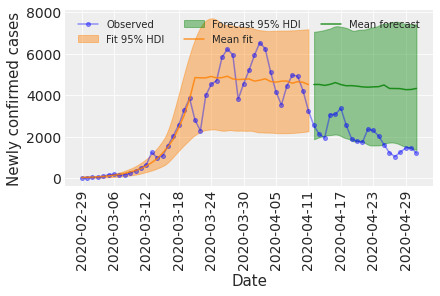

In [15]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
    
ax.plot(np.arange(len(Id_covid19_series)), Id_covid19_series, "o-", ms=4, \
        color="blue", alpha=0.4, label="Observed")
az.plot_hdi(np.arange(fit_ndays), pp_fit, hdi_prob=0.95, \
            color="#FF7F00", fill_kwargs={"alpha": 0.4, "label": "Fit 95% HDI"})
az.plot_hdi(np.arange(fit_ndays, len(Id_covid19_series)), pp_forecast, hdi_prob=0.95, \
            color="green", fill_kwargs={"alpha": 0.4, "label": "Forecast 95% HDI"})
ax.plot(np.arange(fit_ndays), pp_fit.mean(0), color="#FF7F00", alpha=0.8, label="Mean fit")
ax.plot(np.arange(fit_ndays, len(Id_covid19_series)), pp_forecast.mean(0), color="green", \
        alpha=0.8, label="Mean forecast")

x_day_interval = max(1, (len(d.dates)) // 10)
plt.xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
plt.xlabel("Date")
plt.ylabel("Newly confirmed cases")
ax.legend(ncol=3, fontsize=10, loc="upper center")
plt.show()

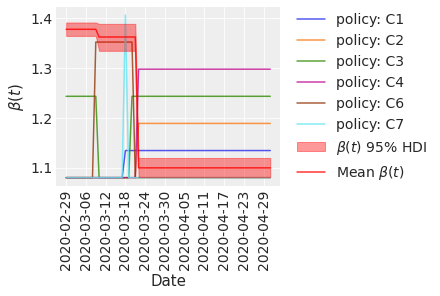

In [16]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

rmax = np.max(np.array(pp_betat))
rmin = np.min(np.array(pp_betat))
n_policy_valid = np.sum((np.sum(np.array(d.policy_series), axis=0)>0).astype(int))
j = 0
for i, p in enumerate(d._DataReader__policy_reader.PolicyType):
    if np.sum(np.array(d.policy_series)[:, i]) > 0:
        j += 1
        plt.plot((rmax-rmin)*np.array(d.policy_series)[:, i]*j/(1.0*n_policy_valid)+rmin, \
                 alpha=0.8, label="policy: "+p, zorder=0.8)
        pass
    pass
az.plot_hdi(np.arange(len(Id_covid19_series)), pp_betat, hdi_prob=0.95, smooth=False, \
                  color="red", fill_kwargs={"alpha": 0.4, "label": r"$\beta(t)$ 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), pp_betat.mean(0), color="red", \
        alpha=0.8, label=r"Mean $\beta(t)$")
x_day_interval = max(1, (len(d.dates)) // 10)
plt.xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
plt.xlabel("Date")
plt.ylabel(r"$\beta(t)$")
plt.legend(bbox_to_anchor=(1.05, 1.0), borderaxespad=0)
plt.show()

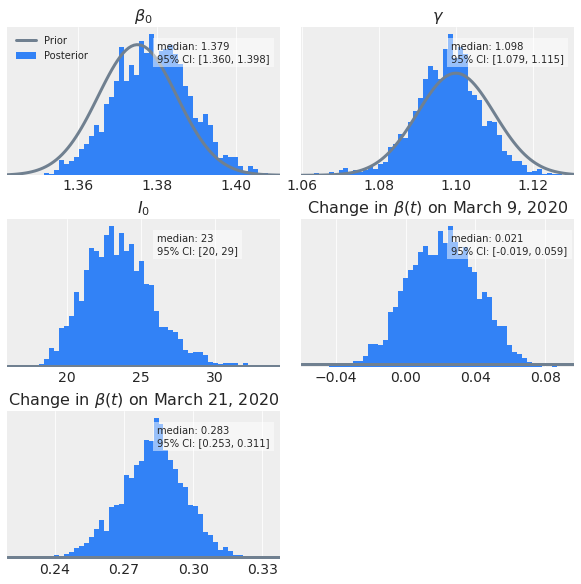

In [17]:
fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor('white')

gs = fig.add_gridspec(3, 2)

ax_beta0 = fig.add_subplot(gs[0, 0])
ax_gamma = fig.add_subplot(gs[0, 1])
ax_I0 = fig.add_subplot(gs[1, 0])
ax_beta_change_1 = fig.add_subplot(gs[1, 1])
ax_beta_change_2 = fig.add_subplot(gs[2, 0])

ax = ax_beta0
posterior = np.array(trace.posterior[r"$\beta_{0}$"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=1.375, scale=0.01), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"$\beta_{0}$")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1], ncol=1, fontsize=10, loc="upper left")

ax = ax_gamma
posterior = np.array(trace.posterior[r'$\gamma$']).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.norm.pdf(x, loc=1.1, scale=0.01), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r'$\gamma$')
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_I0
posterior = np.array(trace.posterior[r"$I_{0}$"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, HalfCauchy_PDF(x, beta=500), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"$I_{0}$")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 0)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 0)
ci_right = truncate_number(ci_right, 0)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_beta_change_1
posterior = np.array(trace.posterior[r"Change in $\beta(t)$ on March 9, 2020"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.uniform.pdf(x, loc=-1.0, scale=2.0), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"Change in $\beta(t)$ on March 9, 2020")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

ax = ax_beta_change_2
posterior = np.array(trace.posterior[r"Change in $\beta(t)$ on March 21, 2020"]).flatten()
ax.hist(posterior, bins=50, density=True, color="#3282F6", label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.uniform.pdf(x, loc=-1.0, scale=2.0), label='Prior', \
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_title(r"Change in $\beta(t)$ on March 21, 2020")
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
# print median and 95% CI
med = truncate_number(median(posterior), 3)
ci_1eft, ci_right = CI(posterior)
ci_1eft = truncate_number(ci_1eft, 3)
ci_right = truncate_number(ci_right, 3)
text = "median: {}\n95% CI: [{}, {}]".format(med, ci_1eft, ci_right)
ax.text(0.55, 0.9, text, horizontalalignment='left', verticalalignment='top', \
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), \
        fontsize=10)

plt.show()

E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\pairplot.py:242: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


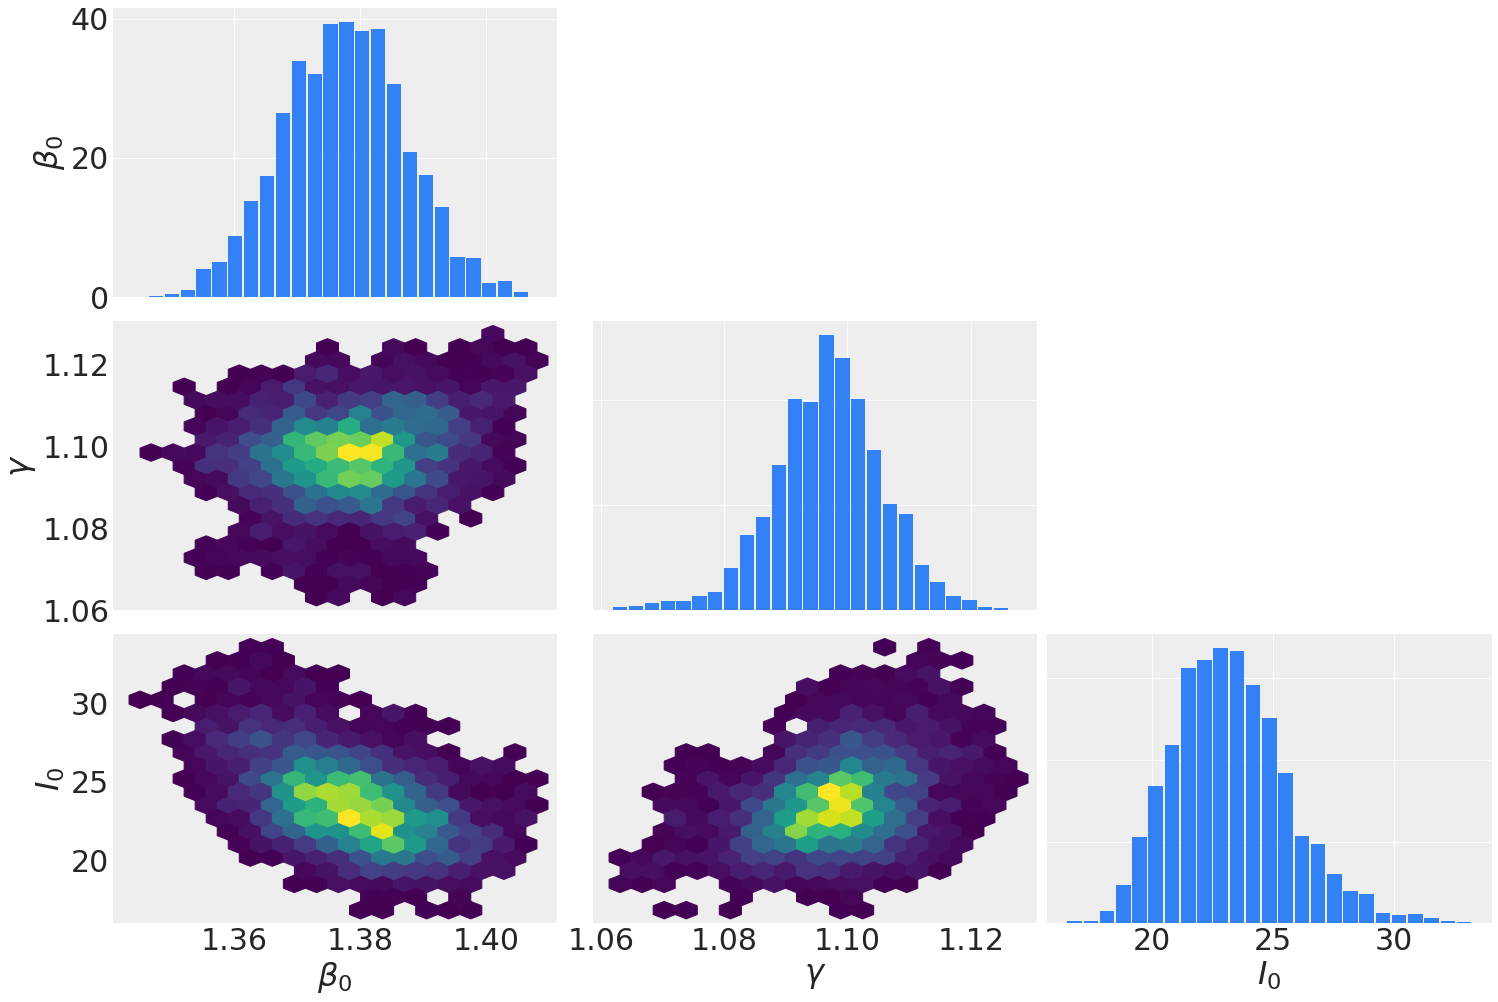

In [18]:
subplots = az.plot_pair(
    trace,
    var_names = [r'$\beta_{0}$', \
                 r"$\gamma$", \
                 r'$I_{0}$'],
    kind = "hexbin",
    divergences = True,
    textsize = 30,
    marginals = True,
    marginal_kwargs = {"kind": "hist", "hist_kwargs": {"bins": 25, "density": True, "color": "#3282F6"}}
).tolist()

for i in range(len(subplots)):
    for j in range(len(subplots[0])):
        ax = subplots[i][j]
        if type(ax.axes) != type(None):
            ax.axes.xaxis.set_major_locator(MaxNLocator(4)) 
            pass
        pass
    pass

plt.show()

In [19]:
model_loo = az.loo(trace, model, var_name=r'Fit')
print(model_loo.loo)
print(model_loo.p_loo)

-315.25262309056234
4.598668683923449


E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


In [20]:
model_waic = az.waic(trace, model, var_name=r'Fit')
print(model_waic.waic)
print(model_waic.p_waic)

-315.1251911101169
4.471236703477911


E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
